In [134]:
import pandas as pd

df = pd.read_csv("stock_weekly.csv")

df.head(3)


,Date,AABA_Open,AAPL_Open,all_stocks_Open,AMZN_Open,AXP_Open,BA_Open,CAT_Open,CSCO_Open,CVX_Open,...,MSFT_Volume,NKE_Volume,PFE_Volume,PG_Volume,TRV_Volume,UNH_Volume,UTX_Volume,VZ_Volume,WMT_Volume,XOM_Volume
0,2010-01-04,16.94,30.49,83.09,136.25,40.81,55.72,57.65,24.11,78.20,...,38414185.0,11972588.0,52087601.00,9190873.00,3715991.0,12200889.0,6104078.0,15173008.00,20753890.0,27811317.0
1,2010-01-11,17.22,30.66,82.80,133.43,40.83,56.25,58.55,24.60,79.22,...,55692283.2,8958045.6,37414200.00,10154887.00,5591877.6,9433384.2,4836165.2,24269981.80,12836606.0,29600915.0
2,2010-01-18,16.65,29.88,83.58,128.99,41.27,60.07,63.01,24.44,79.52,...,65234276.5,8934966.0,56172258.25,13834836.25,3879564.0,12530357.0,4610869.5,23734768.75,15317025.0,26108320.5


# Index only

In [135]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df.set_index('Date', inplace=True)

df.index = df.index.strftime('%d/%m/%Y')

df.head(3)

,AABA_Open,AAPL_Open,all_stocks_Open,AMZN_Open,AXP_Open,BA_Open,CAT_Open,CSCO_Open,CVX_Open,GE_Open,...,MSFT_Volume,NKE_Volume,PFE_Volume,PG_Volume,TRV_Volume,UNH_Volume,UTX_Volume,VZ_Volume,WMT_Volume,XOM_Volume
Date,,,,,,,,,,,,,,,,,,,,,
04/01/2010,16.94,30.49,83.09,136.25,40.81,55.72,57.65,24.11,78.20,15.22,...,38414185.0,11972588.0,52087601.00,9190873.00,3715991.0,12200889.0,6104078.0,15173008.00,20753890.0,27811317.0
11/01/2010,17.22,30.66,82.80,133.43,40.83,56.25,58.55,24.60,79.22,15.46,...,55692283.2,8958045.6,37414200.00,10154887.00,5591877.6,9433384.2,4836165.2,24269981.80,12836606.0,29600915.0
18/01/2010,16.65,29.88,83.58,128.99,41.27,60.07,63.01,24.44,79.52,16.58,...,65234276.5,8934966.0,56172258.25,13834836.25,3879564.0,12530357.0,4610869.5,23734768.75,15317025.0,26108320.5


In [136]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Split the data into features and target arrays before scaling
X = df.drop(['all_stocks_Close'], axis=1)  # All columns except the target
y = df['all_stocks_Close']  # Target column

# Calculate the index for the end of the training and validation sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

# Split the data chronologically
X_train_raw = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val_raw = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test_raw = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Scale the features using MinMaxScaler after the split
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)


## GradientBoostingRegressor

In [137]:
# Demora10 min a correr, grid search para encontrar os melhores parametros

'''from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200, 300, 450],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
    # Add more parameters here if needed
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # Number of folds in cross-validation
                           n_jobs=-1,  # Use all available cores
                           scoring='neg_mean_squared_error',
                           verbose=2)

# Fit the grid search model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters found: ", best_params)

# Use the best estimator for making predictions
best_rf = grid_search.best_estimator_

# Make predictions with the best estimator
y_pred_val_best = best_rf.predict(X_val)
y_pred_test_best = best_rf.predict(X_test)

# Compute metrics with the best estimator
rmse_val_best = mean_squared_error(y_val, y_pred_val_best, squared=False)
mse_val_best = mean_squared_error(y_val, y_pred_val_best)
mae_val_best = mean_absolute_error(y_val, y_pred_val_best)
mape_val_best = np.mean(np.abs((y_val - y_pred_val_best) / y_val)) * 100

rmse_test_best = mean_squared_error(y_test, y_pred_test_best, squared=False)
mse_test_best = mean_squared_error(y_test, y_pred_test_best)
mae_test_best = mean_absolute_error(y_test, y_pred_test_best)
mape_test_best = np.mean(np.abs((y_test - y_pred_test_best) / y_test)) * 100

# Print metrics for the model with the best parameters
print("\nEvaluation Metrics for the Validation Set with Best Parameters:")
print(f"RMSE: {rmse_val_best:.3f}, MSE: {mse_val_best:.3f}, MAE: {mae_val_best:.3f}, MAPE: {mape_val_best:.3f}")

print("\nEvaluation Metrics for the Test Set with Best Parameters:")
print(f"RMSE: {rmse_test_best:.3f}, MSE: {mse_test_best:.3f}, MAE: {mae_test_best:.3f}, MAPE: {mape_test_best:.3f}")
'''

'from sklearn.model_selection import GridSearchCV\n\n# Define the parameter grid for RandomForestRegressor\nparam_grid = {\n    \'n_estimators\': [50, 100, 200, 300, 450],  # Number of trees in the forest\n    \'max_depth\': [None, 5, 10, 20],  # Maximum depth of the tree\n    \'min_samples_split\': [2, 5],  # Minimum number of samples required to split an internal node\n    \'min_samples_leaf\': [1, 2],  # Minimum number of samples required to be at a leaf node\n    # Add more parameters here if needed\n}\n\n# Initialize the grid search model\ngrid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), \n                           param_grid=param_grid, \n                           cv=5,  # Number of folds in cross-validation\n                           n_jobs=-1,  # Use all available cores\n                           scoring=\'neg_mean_squared_error\', \n                           verbose=2)\n\n# Fit the grid search model on the training data\ngrid_search.fit(X_train

In [138]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the GBM model
model = GradientBoostingRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=450)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Compute metrics for the validation set
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Compute metrics for the test set
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Create DataFrames to display metrics
metrics_df_val = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Validation Set': [round(rmse_val, 3), round(mse_val, 3), round(mae_val, 3), round(mape_val, 3)]
})

metrics_df_test = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Test Set': [round(rmse_test, 3), round(mse_test, 3), round(mae_test, 3), round(mape_test, 3)]
})

# Display the metrics tables
print("Evaluation Metrics for the Validation Set:")
print(metrics_df_val)
print("\nEvaluation Metrics for the Test Set:")
print(metrics_df_test)


Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          14.115
1    MSE         199.240
2    MAE          10.613
3   MAPE           6.846

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    20.948
1    MSE   438.824
2    MAE    19.108
3   MAPE    11.991


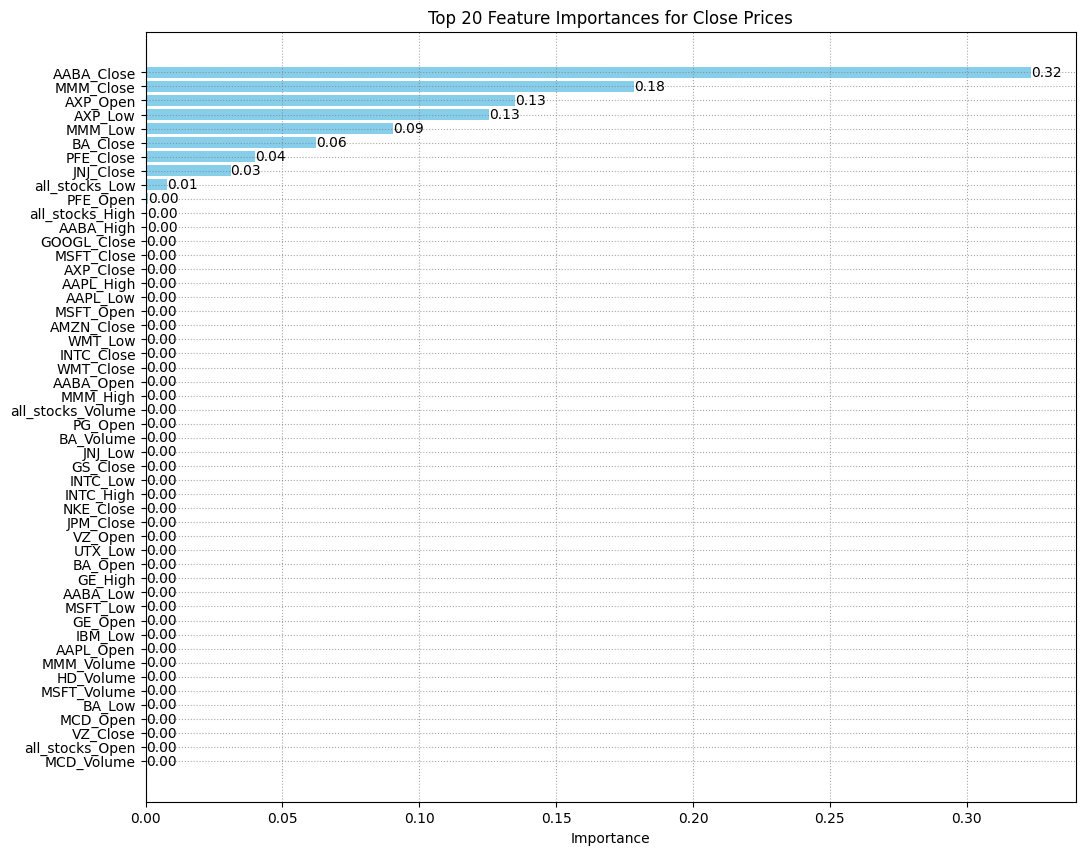

In [139]:
import matplotlib.pyplot as plt

feature_names = X.columns
importances = model.feature_importances_

# Sort the feature importances in decreasing order and get the indexes
sorted_idx = np.argsort(importances)[::-1]

# Use the sorted indexes to reorder the feature names and their importances
sorted_feature_names = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(12, 10))  # Increase the figure size for better readability
N = 50  # Number of features to display
# Plot only the top N importances, slicing the sorted arrays
plt.barh(range(N), sorted_importances[:N], color='skyblue', tick_label=sorted_feature_names[:N])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances for Close Prices')
plt.gca().invert_yaxis()  # Make sure the top feature is at the top of the chart
# Adding gridlines for better readability
plt.grid(True, linestyle=':', color='grey', alpha=0.7)
# Annotate the bars with the importance values
for i in range(N):
    plt.text(sorted_importances[i], i, f'{sorted_importances[i]:.2f}', va='center')
plt.show()



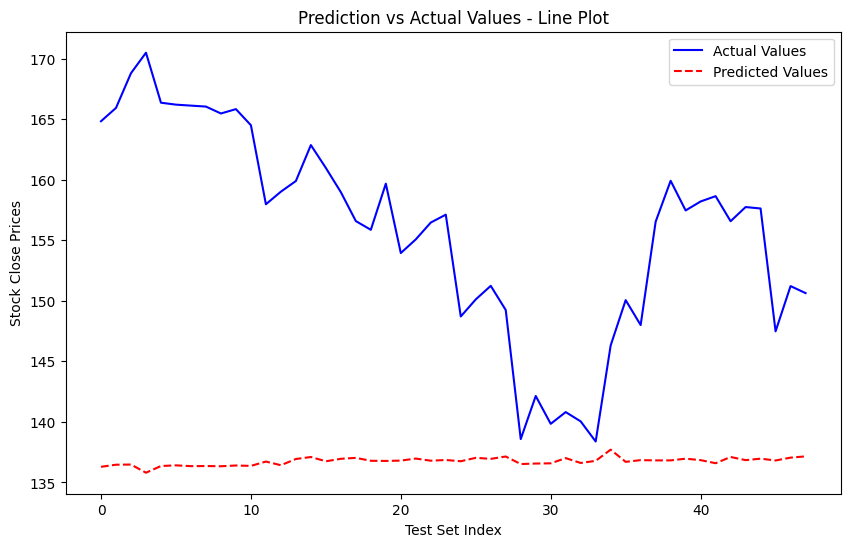

In [141]:
import matplotlib.pyplot as plt

# Create a line plot to visualize the trend of predictions vs actual values over the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Values', color='blue')
plt.plot(y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Line Plot')
plt.xlabel('Test Set Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()


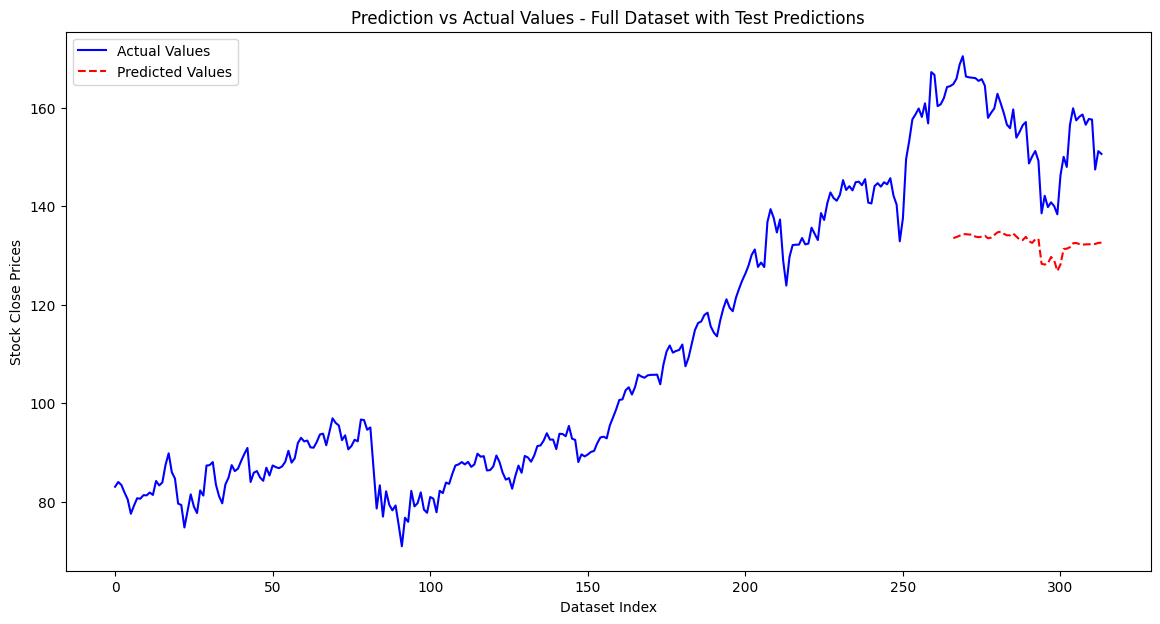

In [64]:
import matplotlib.pyplot as plt

# Concatenate the training, validation, and test set indices and values to plot the entire dataset
y_all = pd.concat([y_train, y_val, y_test])
predictions = np.concatenate([model.predict(X_train), model.predict(X_val), y_pred_test])

# Plotting the entire dataset with predictions overlaid on the test set
plt.figure(figsize=(14, 7))
plt.plot(y_all.reset_index(drop=True), label='Actual Values', color='blue')
# Only overlay predictions on the test set portion
plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_pred_test)), y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Full Dataset with Test Predictions')
plt.xlabel('Dataset Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()



## RandomForestRegressor

In [142]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate the index for the end of the training and validation sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

# Split the data into features and target arrays without scaling
X = df.drop(['all_stocks_Close'], axis=1)  # All columns except the target
y = df['all_stocks_Close']  # Target column

# Split the data chronologically
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]

# Define the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Compute metrics for the validation set
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100  # Calculating MAPE

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Compute metrics for the test set
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100  # Calculating MAPE

# Create DataFrames to display metrics
metrics_df_val = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Validation Set': [round(rmse_val, 3), round(mse_val, 3), round(mae_val, 3), round(mape_val, 3)]
})

metrics_df_test = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Test Set': [round(rmse_test, 3), round(mse_test, 3), round(mae_test, 3), round(mape_test, 3)]
})

# Display the metrics tables
print("Evaluation Metrics for the Validation Set:")
print(metrics_df_val)
print("\nEvaluation Metrics for the Test Set:")
print(metrics_df_test)


Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          16.660
1    MSE         277.547
2    MAE          13.584
3   MAPE           8.854

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    24.327
1    MSE   591.816
2    MAE    23.423
3   MAPE    14.846


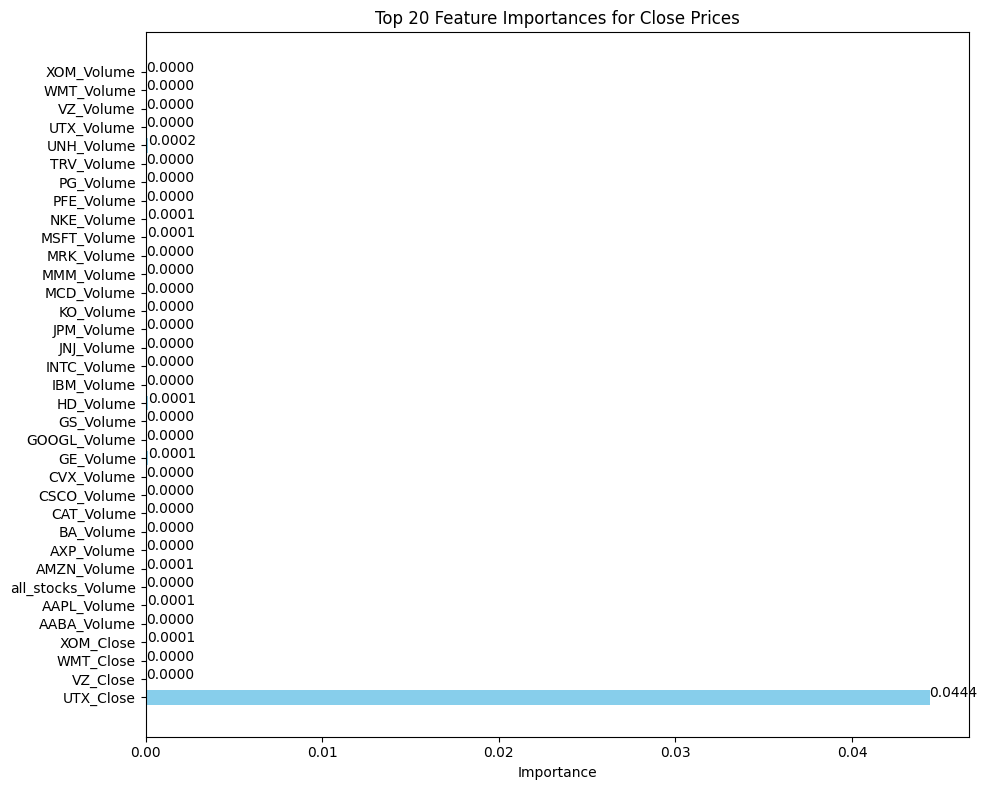

In [143]:
import matplotlib.pyplot as plt

# Extract feature importances from the model
feature_importances = model.feature_importances_
feature_names = X.columns

# Create a pandas DataFrame to make handling easier
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Only select the top N features for readability, adjust N as necessary
N = 35
importances_df = importances_df.tail(N)

# Plotting
plt.figure(figsize=(10, 8))  # You can adjust the figure size as needed
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances for Close Prices')
# You no longer need to invert the y-axis since we're already sorting ascending and plotting the last N
for index, value in enumerate(importances_df['Importance']):
    plt.text(value, index, f'{value:.4f}')  # Annotate bars with their numeric value
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()

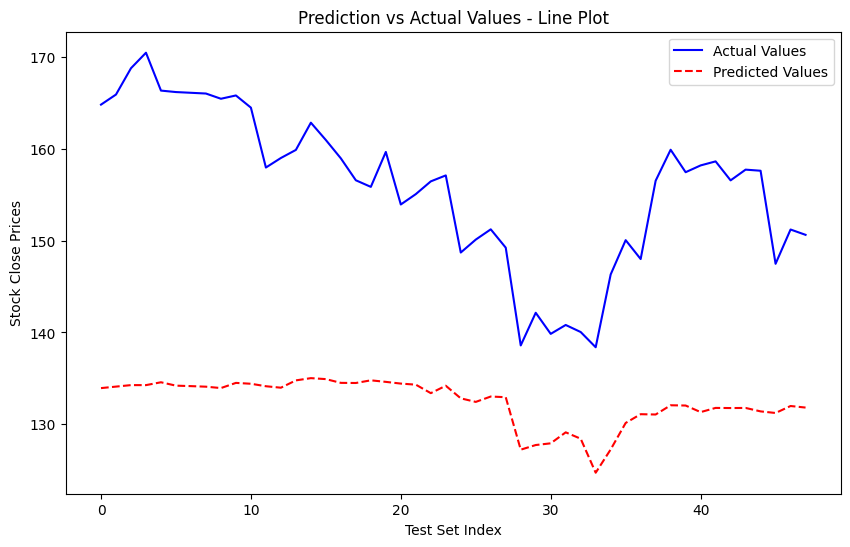

In [144]:
import matplotlib.pyplot as plt

# Create a line plot to visualize the trend of predictions vs actual values over the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Values', color='blue')
plt.plot(y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Line Plot')
plt.xlabel('Test Set Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()


# Sentimental only

In [145]:
import pandas as pd

sentimental = pd.read_csv("sentimental.csv")

sentimental.head(3)

,Company,Date,Title,Abstract,sentiment_abstract,sentiment_category_abstract
0,3M,07/04/2015,hp comes to terms with the cloud,hewlett-packard has decided it cannot compete ...,0.5423,Positive
1,3M,21/03/2013,addressing fears about led light bulbs,a column about led light bulbs generated a lot...,-0.4939,Negative
2,3M,18/04/2010,companies slowly join cloud-computing,"amazon, microsoft, google and others are now t...",-0.0644,Neutral


In [146]:
import pandas as pd

# Assuming 'sentimental' has a 'Date' column in the format 'dd/mm/yyyy'
sentimental['Date'] = pd.to_datetime(sentimental['Date'], format='%d/%m/%Y')

# Normalize 'sentimental' dates to the start of the week (Monday)
# Convert dates to the corresponding period ('W' for weekly) then to timestamp
sentimental['Week_Start'] = sentimental['Date'].dt.to_period('W').dt.start_time

# Convert 'df' index to datetime, assuming the index format is 'dd/mm/yyyy'
df.index = pd.to_datetime(df.index, dayfirst=True).normalize()

# Select specific columns from df
columns_to_include = ['all_stocks_Open', 'all_stocks_Close', 'all_stocks_Volume', 'all_stocks_High', 'all_stocks_Low']
df_selected = df[columns_to_include]

# Group 'sentimental' by 'Week_Start' for the average sentiment per week
weekly_sentimental = sentimental.groupby('Week_Start').agg({'sentiment_abstract': 'mean'}).reset_index()

# Merge df_selected with weekly_sentimental on the index of df_selected and 'Week_Start' of weekly_sentimental
merged_df = df_selected.merge(weekly_sentimental, left_index=True, right_on='Week_Start', how='left')


In [147]:
merged_df.head(2)

,all_stocks_Open,all_stocks_Close,all_stocks_Volume,all_stocks_High,all_stocks_Low,Week_Start,sentiment_abstract
NaN,83.09,83.02,3043663.0,83.45,82.67,2010-01-04,NaN
56.0,82.80,83.98,3784318.2,84.60,81.70,2010-01-11,0.0


In [148]:
merged_df = merged_df.drop(columns=['Company', 'Title', 'Abstract', 'Week_Start'], errors='ignore')


In [149]:
# Calculate the total number of NaNs per column
nan_counts = merged_df.isna().sum()

# Filter and print results to show only columns with NaNs
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)


sentiment_abstract    140
dtype: int64


In [150]:
# Fill NaNs with zero
merged_df.fillna(0, inplace=True)

In [151]:
# Split the data into features and target arrays before scaling
X = merged_df.drop(['all_stocks_Close'], axis=1)  # All columns except the target
y = merged_df['all_stocks_Close']  # Target column

# Calculate the index for the end of the training and validation sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

# Split the data chronologically
X_train_raw = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val_raw = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test_raw = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]


# Identify non-numeric columns
non_numeric_columns = X_train_raw.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns (like datetime)
X_train_raw = X_train_raw.drop(columns=non_numeric_columns)
X_val_raw = X_val_raw.drop(columns=non_numeric_columns)
X_test_raw = X_test_raw.drop(columns=non_numeric_columns)

# Now apply the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)


In [153]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the GBM model
model = GradientBoostingRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=450)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Compute metrics for the validation set
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Compute metrics for the test set
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Create DataFrames to display metrics
metrics_df_val = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Validation Set': [round(rmse_val, 3), round(mse_val, 3), round(mae_val, 3), round(mape_val, 3)]
})

metrics_df_test = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Test Set': [round(rmse_test, 3), round(mse_test, 3), round(mae_test, 3), round(mape_test, 3)]
})

# Display the metrics tables
print("Evaluation Metrics for the Validation Set:")
print(metrics_df_val)
print("\nEvaluation Metrics for the Test Set:")
print(metrics_df_test)
print()
'''
Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          16.660
1    MSE         277.547
2    MAE          13.584
3   MAPE           8.854

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    24.327
1    MSE   591.816
2    MAE    23.423
3   MAPE    14.846'''



Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          13.744
1    MSE         188.895
2    MAE          10.229
3   MAPE           6.595

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    19.873
1    MSE   394.943
2    MAE    18.045
3   MAPE    11.318



'\nEvaluation Metrics for the Validation Set:\n  Metric  Validation Set\n0   RMSE          16.660\n1    MSE         277.547\n2    MAE          13.584\n3   MAPE           8.854\n\nEvaluation Metrics for the Test Set:\n  Metric  Test Set\n0   RMSE    24.327\n1    MSE   591.816\n2    MAE    23.423\n3   MAPE    14.846'

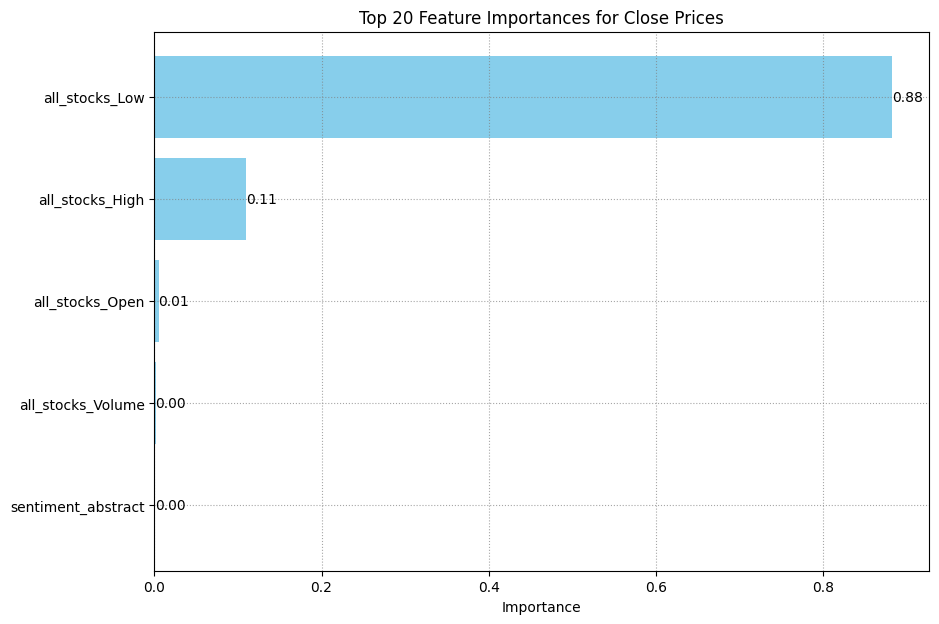

In [154]:
import matplotlib.pyplot as plt

feature_names = X.columns
importances = model.feature_importances_

# Sort the feature importances in decreasing order and get the indexes
sorted_idx = np.argsort(importances)[::-1]

# Use the sorted indexes to reorder the feature names and their importances
sorted_feature_names = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 7))  # Increase the figure size for better readability
N = 5  # Number of features to display
# Plot only the top N importances, slicing the sorted arrays
plt.barh(range(N), sorted_importances[:N], color='skyblue', tick_label=sorted_feature_names[:N])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances for Close Prices')
plt.gca().invert_yaxis()  # Make sure the top feature is at the top of the chart
# Adding gridlines for better readability
plt.grid(True, linestyle=':', color='grey', alpha=0.7)
# Annotate the bars with the importance values
for i in range(N):
    plt.text(sorted_importances[i], i, f'{sorted_importances[i]:.2f}', va='center')
plt.show()



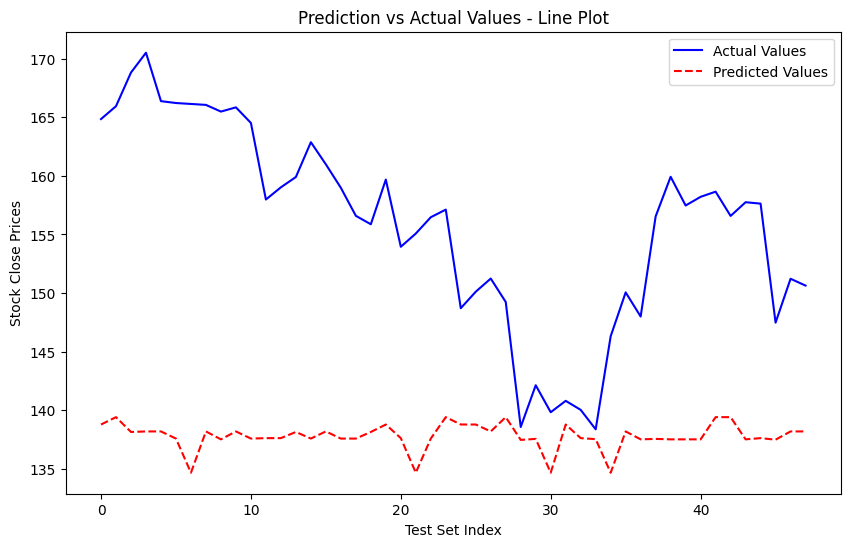

In [155]:
# Create a line plot to visualize the trend of predictions vs actual values over the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Values', color='blue')
plt.plot(y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Line Plot')
plt.xlabel('Test Set Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()


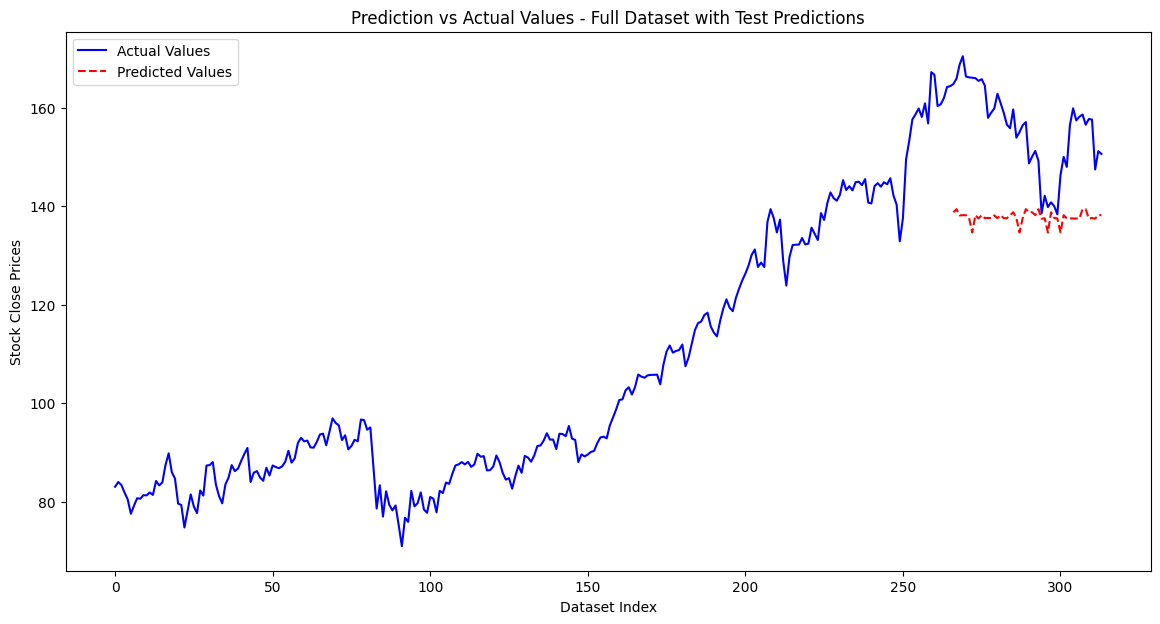

In [156]:
import matplotlib.pyplot as plt

# Concatenate the training, validation, and test set indices and values to plot the entire dataset
y_all = pd.concat([y_train, y_val, y_test])
predictions = np.concatenate([model.predict(X_train), model.predict(X_val), y_pred_test])

# Plotting the entire dataset with predictions overlaid on the test set
plt.figure(figsize=(14, 7))
plt.plot(y_all.reset_index(drop=True), label='Actual Values', color='blue')
# Only overlay predictions on the test set portion
plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_pred_test)), y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Full Dataset with Test Predictions')
plt.xlabel('Dataset Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()



# Combination of everything - not great

In [157]:
import pandas as pd

# Assuming 'sentimental' has a 'Date' column in the format 'dd/mm/yyyy'
sentimental['Date'] = pd.to_datetime(sentimental['Date'], format='%d/%m/%Y')

# Normalize 'sentimental' dates to the start of the week (Monday)
# First, convert dates to the corresponding period ('W' for weekly)
# Then, convert the period to timestamp to align with df's datetime index
sentimental['Week_Start'] = sentimental['Date'].dt.to_period('W').dt.start_time


# If the 'df' index is in the format 'dd/mm/yyyy'
df.index = pd.to_datetime(df.index, dayfirst=True).normalize()


# Group 'sentimental' by 'Week_Start' if needed, e.g., average sentiment per week
weekly_sentimental = sentimental.groupby('Week_Start').agg({'sentiment_abstract': 'mean'}).reset_index()

# Merge 'df' with 'weekly_sentimental' on the index of 'df' and 'Week_Start' of 'weekly_sentimental'
merged_df = df.merge(weekly_sentimental, left_index=True, right_on='Week_Start', how='left')


In [158]:
merged_df.head()

,AABA_Open,AAPL_Open,all_stocks_Open,AMZN_Open,AXP_Open,BA_Open,CAT_Open,CSCO_Open,CVX_Open,GE_Open,...,PFE_Volume,PG_Volume,TRV_Volume,UNH_Volume,UTX_Volume,VZ_Volume,WMT_Volume,XOM_Volume,Week_Start,sentiment_abstract
NaN,16.94,30.49,83.09,136.25,40.81,55.72,57.65,24.11,78.20,15.22,...,52087601.00,9190873.00,3715991.0,12200889.0,6104078.0,15173008.00,20753890.0,27811317.0,2010-01-04,NaN
56.0,17.22,30.66,82.80,133.43,40.83,56.25,58.55,24.60,79.22,15.46,...,37414200.00,10154887.00,5591877.6,9433384.2,4836165.2,24269981.80,12836606.0,29600915.0,2010-01-11,0.0
NaN,16.65,29.88,83.58,128.99,41.27,60.07,63.01,24.44,79.52,16.58,...,56172258.25,13834836.25,3879564.0,12530357.0,4610869.5,23734768.75,15317025.0,26108320.5,2010-01-18,NaN
NaN,16.78,29.76,83.82,126.20,42.24,60.60,59.76,24.54,78.96,16.35,...,69149996.40,13354075.40,4875939.0,22896801.0,4655729.0,23088616.60,15075023.2,33646218.8,2010-01-25,NaN
NaN,15.82,29.42,81.46,120.56,37.54,57.54,54.99,22.80,74.08,16.33,...,48932636.40,17043056.80,5299370.0,13566430.0,6082977.6,28843620.20,16209638.4,37151719.6,2010-02-01,NaN


In [159]:
merged_df = merged_df.drop(columns=['Company', 'Title', 'Abstract', 'Week_Start'], errors='ignore')


In [160]:
# Fill NaNs with zero
merged_df.fillna(0, inplace=True)


In [161]:
# Split the data into features and target arrays before scaling
X = merged_df.drop(['all_stocks_Close'], axis=1)  # All columns except the target
y = merged_df['all_stocks_Close']  # Target column

# Calculate the index for the end of the training and validation sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

# Split the data chronologically
X_train_raw = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val_raw = X.iloc[train_size:train_size + val_size]
y_val = y.iloc[train_size:train_size + val_size]

X_test_raw = X.iloc[train_size + val_size:]
y_test = y.iloc[train_size + val_size:]


# Identify non-numeric columns
non_numeric_columns = X_train_raw.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns (like datetime)
X_train_raw = X_train_raw.drop(columns=non_numeric_columns)
X_val_raw = X_val_raw.drop(columns=non_numeric_columns)
X_test_raw = X_test_raw.drop(columns=non_numeric_columns)

# Now apply the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)


In [162]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the GBM model
model = GradientBoostingRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=450)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Compute metrics for the validation set
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Compute metrics for the test set
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Create DataFrames to display metrics
metrics_df_val = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Validation Set': [round(rmse_val, 3), round(mse_val, 3), round(mae_val, 3), round(mape_val, 3)]
})

metrics_df_test = pd.DataFrame({
    'Metric': ['RMSE', 'MSE', 'MAE', 'MAPE'],
    'Test Set': [round(rmse_test, 3), round(mse_test, 3), round(mae_test, 3), round(mape_test, 3)]
})

# Display the metrics tables
print("Evaluation Metrics for the Validation Set:")
print(metrics_df_val)
print("\nEvaluation Metrics for the Test Set:")
print(metrics_df_test)


'''Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          16.660
1    MSE         277.547
2    MAE          13.584
3   MAPE           8.854

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    24.327
1    MSE   591.816
2    MAE    23.423
3   MAPE    14.846

Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          13.737
1    MSE         188.694
2    MAE          10.204
3   MAPE           6.577

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    19.852
1    MSE   394.117
2    MAE    18.036
3   MAPE    11.314'''

Evaluation Metrics for the Validation Set:
  Metric  Validation Set
0   RMSE          14.524
1    MSE         210.960
2    MAE          10.878
3   MAPE           7.015

Evaluation Metrics for the Test Set:
  Metric  Test Set
0   RMSE    21.642
1    MSE   468.381
2    MAE    19.794
3   MAPE    12.426


'Evaluation Metrics for the Validation Set:\n  Metric  Validation Set\n0   RMSE          16.660\n1    MSE         277.547\n2    MAE          13.584\n3   MAPE           8.854\n\nEvaluation Metrics for the Test Set:\n  Metric  Test Set\n0   RMSE    24.327\n1    MSE   591.816\n2    MAE    23.423\n3   MAPE    14.846\n\nEvaluation Metrics for the Validation Set:\n  Metric  Validation Set\n0   RMSE          13.737\n1    MSE         188.694\n2    MAE          10.204\n3   MAPE           6.577\n\nEvaluation Metrics for the Test Set:\n  Metric  Test Set\n0   RMSE    19.852\n1    MSE   394.117\n2    MAE    18.036\n3   MAPE    11.314'

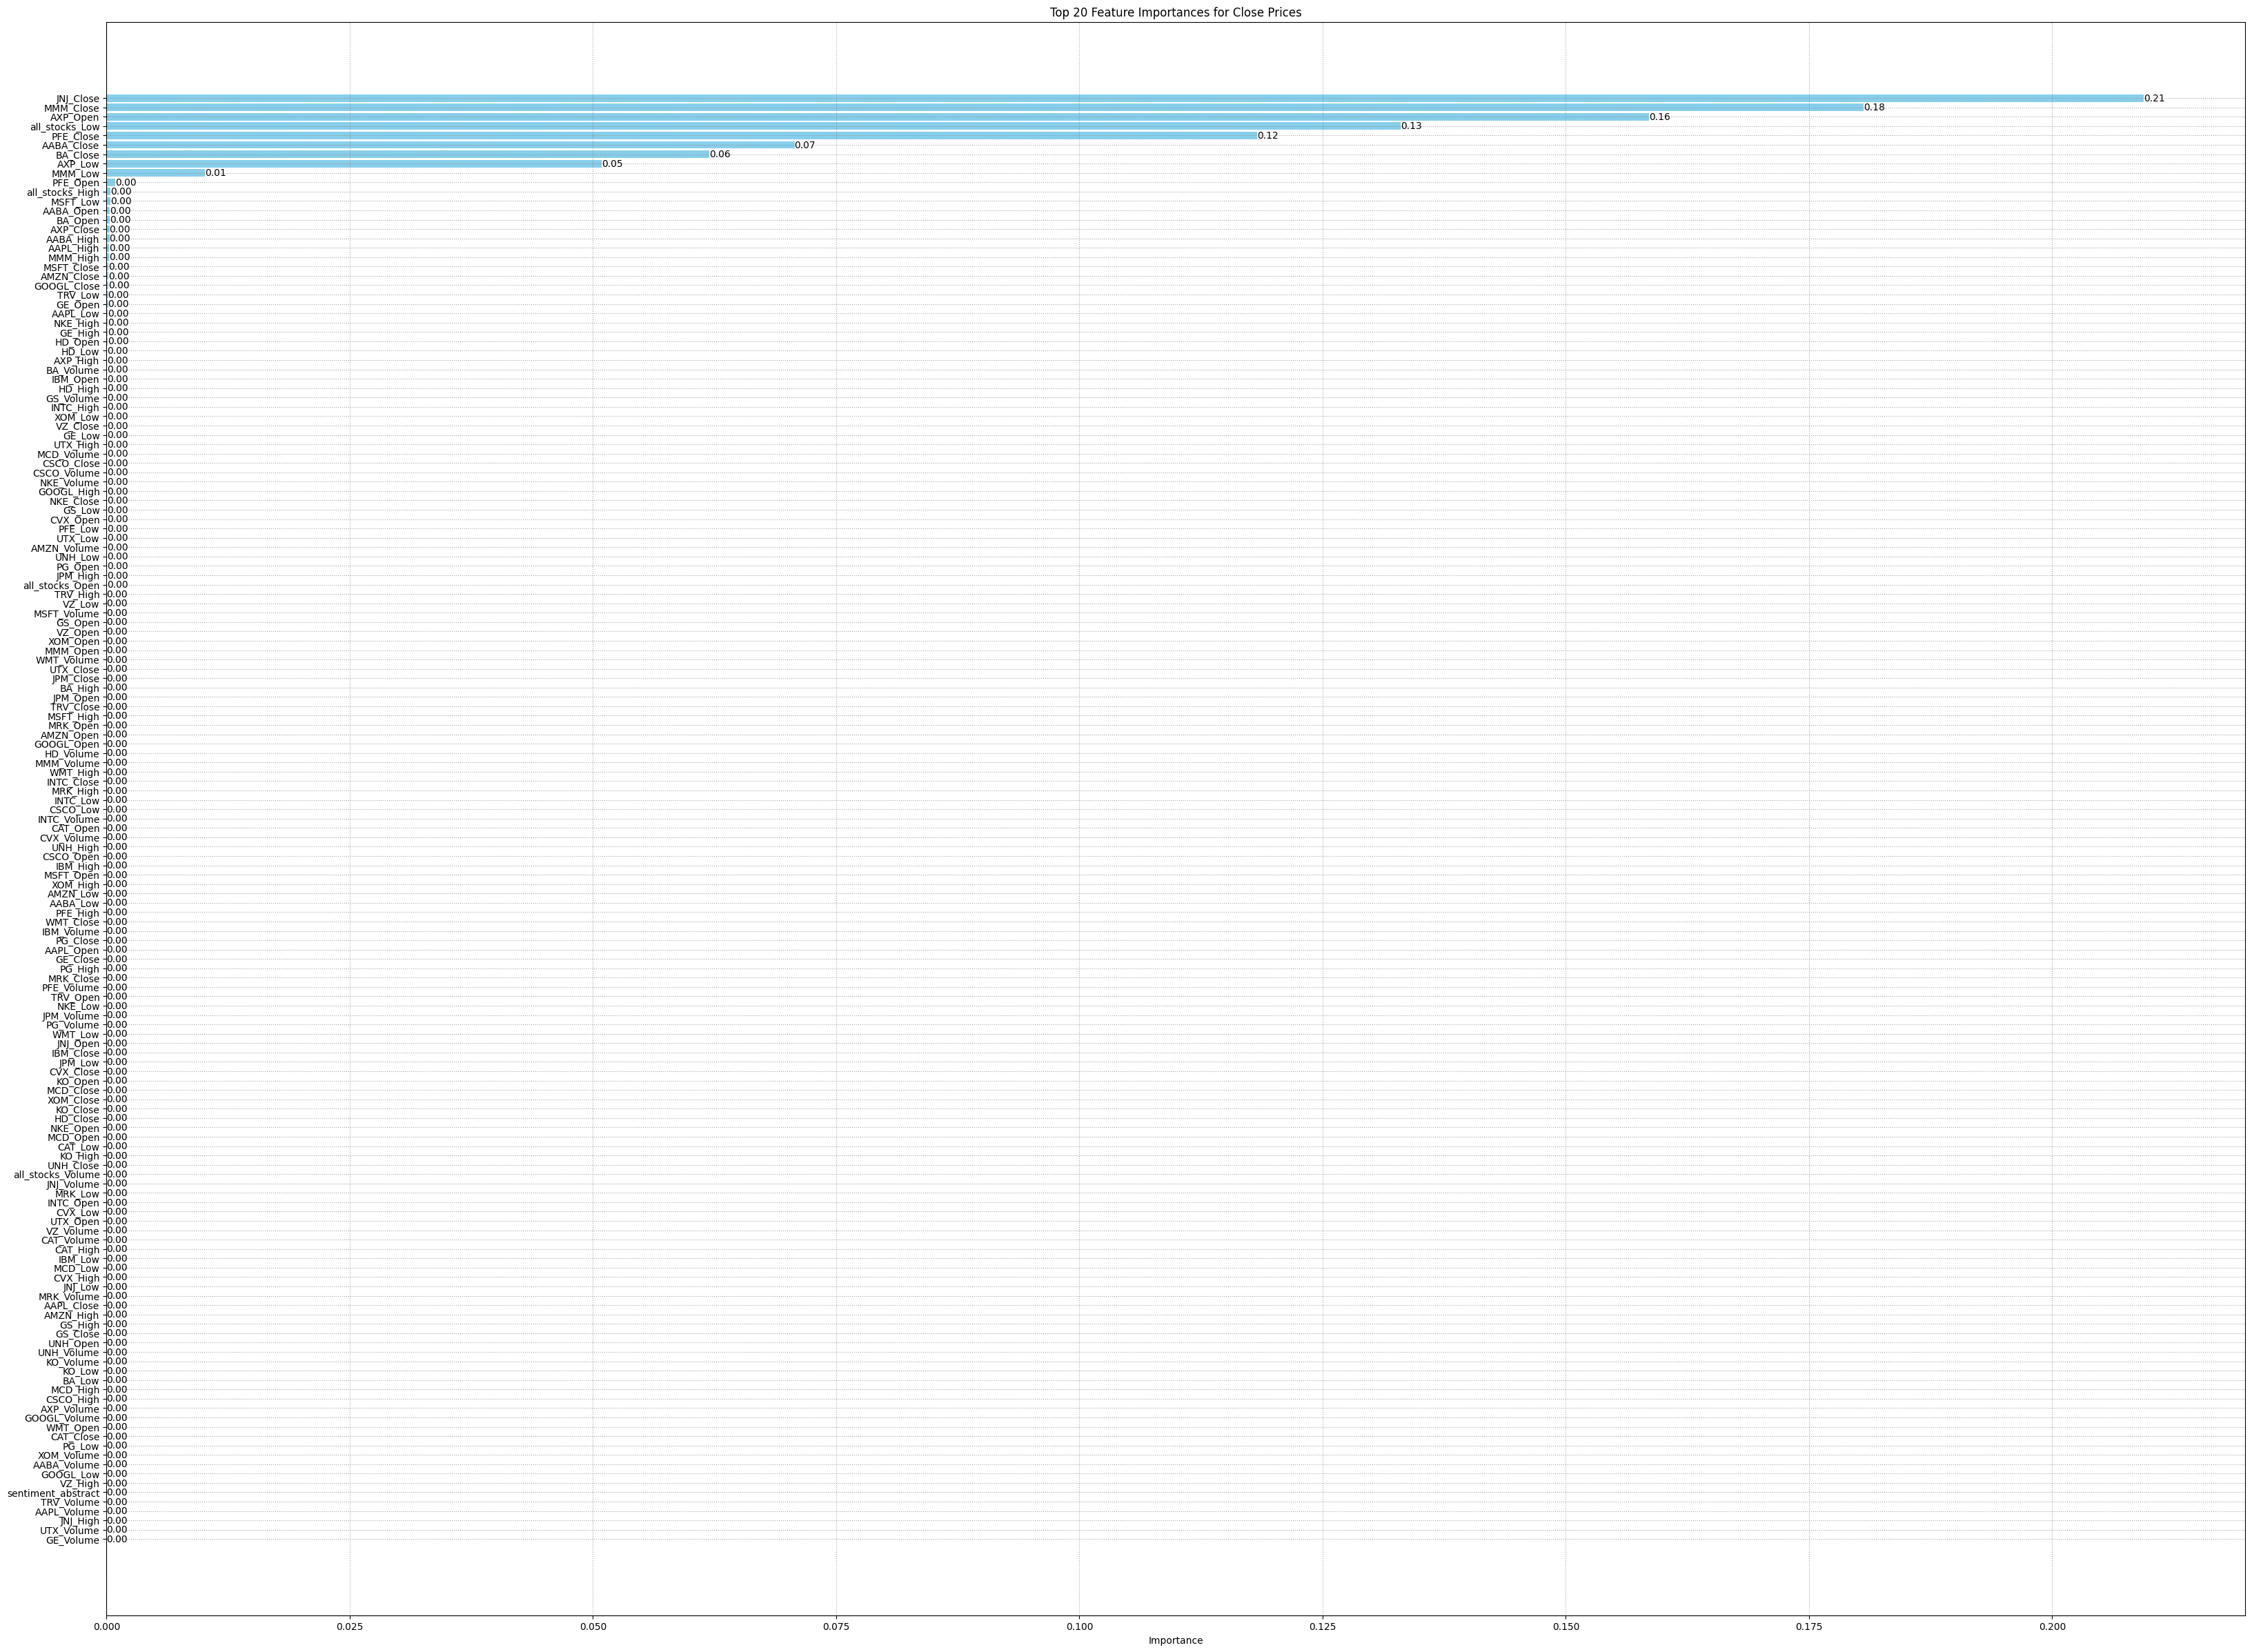

In [163]:
import matplotlib.pyplot as plt

feature_names = X.columns
importances = model.feature_importances_

# Sort the feature importances in decreasing order and get the indexes
sorted_idx = np.argsort(importances)[::-1]

# Use the sorted indexes to reorder the feature names and their importances
sorted_feature_names = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(40, 30))  # Increase the figure size for better readability
N = 155  # Number of features to display
# Plot only the top N importances, slicing the sorted arrays
plt.barh(range(N), sorted_importances[:N], color='skyblue', tick_label=sorted_feature_names[:N])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances for Close Prices')
plt.gca().invert_yaxis()  # Make sure the top feature is at the top of the chart
# Adding gridlines for better readability
plt.grid(True, linestyle=':', color='grey', alpha=0.7)
# Annotate the bars with the importance values
for i in range(N):
    plt.text(sorted_importances[i], i, f'{sorted_importances[i]:.2f}', va='center')
plt.show()



In [164]:
# Get the indexes of the features of interest
idx_sentiment_abstract = np.where(sorted_feature_names == 'sentiment_abstract')[0]
idx_sentiment_category_abstract = np.where(sorted_feature_names == 'sentiment_category_abstract')[0]

# Get the importances of the specific features
importance_sentiment_abstract = sorted_importances[idx_sentiment_abstract] if idx_sentiment_abstract.size > 0 else 0
importance_sentiment_category_abstract = sorted_importances[idx_sentiment_category_abstract] if idx_sentiment_category_abstract.size > 0 else 0

# Print the importances
print(f"Importance of sentiment_abstract: {importance_sentiment_abstract}")
print(f"Importance of sentiment_category_abstract: {importance_sentiment_category_abstract}")


Importance of sentiment_abstract: [5.05355805e-07]
Importance of sentiment_category_abstract: 0


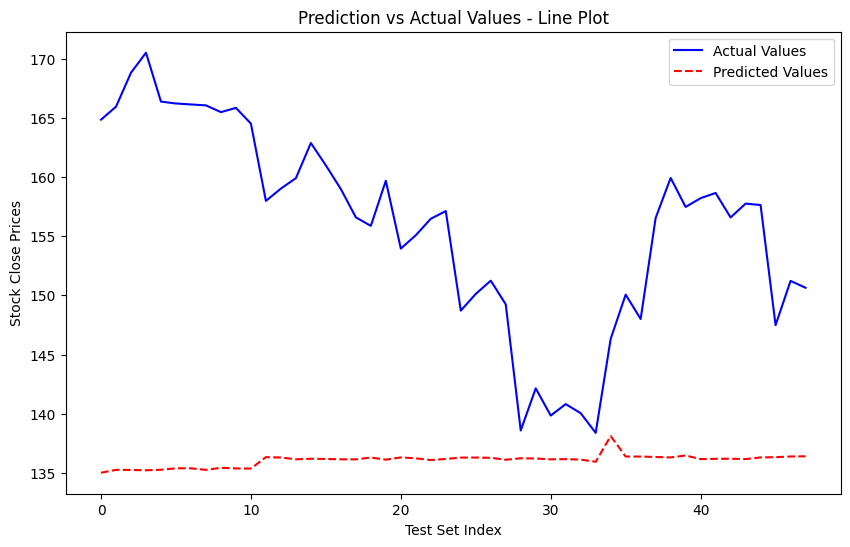

In [165]:
# Create a line plot to visualize the trend of predictions vs actual values over the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Values', color='blue')
plt.plot(y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Line Plot')
plt.xlabel('Test Set Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()


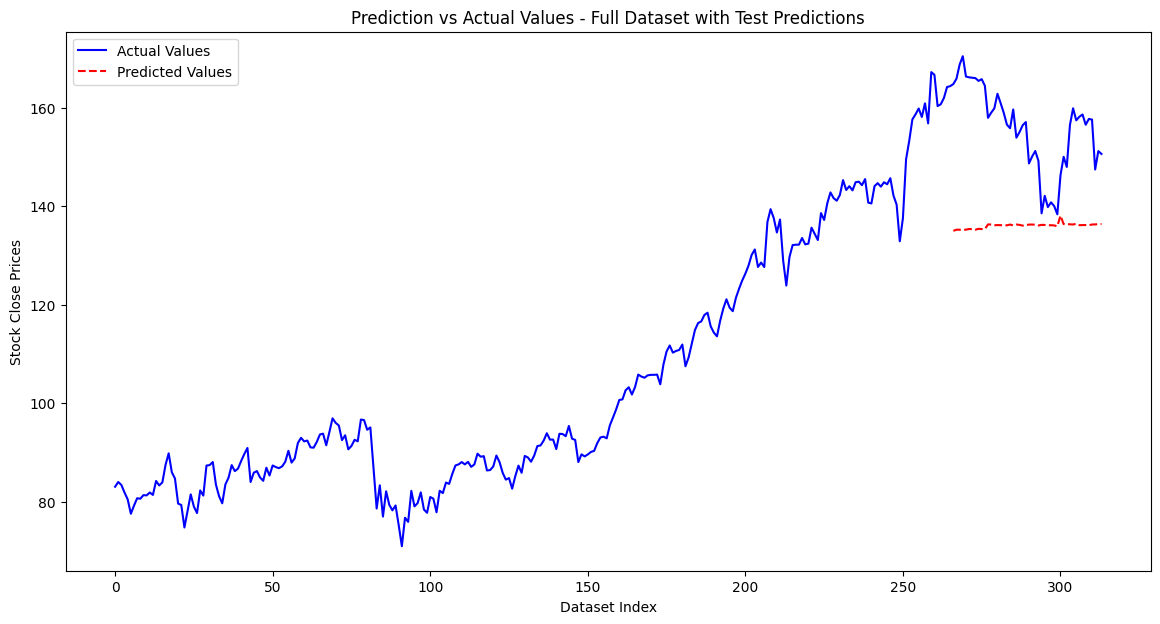

In [166]:
import matplotlib.pyplot as plt

# Concatenate the training, validation, and test set indices and values to plot the entire dataset
y_all = pd.concat([y_train, y_val, y_test])
predictions = np.concatenate([model.predict(X_train), model.predict(X_val), y_pred_test])

# Plotting the entire dataset with predictions overlaid on the test set
plt.figure(figsize=(14, 7))
plt.plot(y_all.reset_index(drop=True), label='Actual Values', color='blue')
# Only overlay predictions on the test set portion
plt.plot(range(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_pred_test)), y_pred_test, label='Predicted Values', color='red', linestyle='--')
plt.title('Prediction vs Actual Values - Full Dataset with Test Predictions')
plt.xlabel('Dataset Index')
plt.ylabel('Stock Close Prices')
plt.legend()
plt.show()

